# Sentiment Analysis of IMDB Reviews

## Problem Definition
Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) technique used to determine the sentiment or emotional tone expressed in a piece of text.

### Objective:
The primary goal of sentiment analysis is to understand the attitude or emotional state conveyed in a text. This could range from positive, negative, or neutral sentiments.

The task is to analyze the sentiment of IMDB movie reviews and classify them as either positive or negative.

### Input and Output
**Input:** The input for the algorithm is a dataset containing movie reviews from IMDB. 

**Features:** The primary feature is the text of the review itself.

**Output:** The output is the sentiment classification of each review as either:
- positive
- negative
  
For each review, the model will output a sentiment label:
- 1 for positive sentiment
- 0 for negative sentiment

### Machine Learning Category
This problem falls under the category of classification in machine learning. Specifically, it is a binary classification problem because the output has two distinct classes: positive and negative sentiments.


## Data Analysis and Processing

### Load the libraries

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import itertools
import os
import matplotlib.image as mpimg
from sklearn import neural_network
from sklearn.datasets import load_digits

%matplotlib inline

warnings.filterwarnings('ignore')

### Visualizing the data

In [2]:
imdb_data = pd.read_csv('dataset/IMDB Dataset.csv')
print("Shape of the dataset:", imdb_data.shape, "\n")
print("Sample of the data:\n", imdb_data.head(10), "\n")

# Summary of the dataset
print("Summary of the dataset:\n", imdb_data.describe(), "\n")

# Sentiment count
imdb_data['sentiment'].value_counts()

Shape of the dataset: (50000, 2) 

Sample of the data:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive 

Summary of the dataset:
                                                    review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today'

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Data statistics

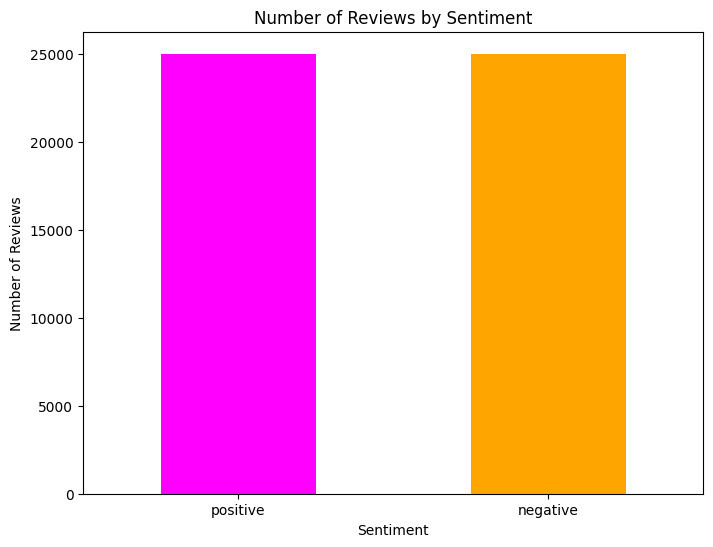

In [3]:
plt.figure(figsize=(8, 6))
imdb_data['sentiment'].value_counts().plot(kind='bar', color=['magenta', 'orange'])
plt.title('Number of Reviews by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

### Text normalisation

In [4]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


# Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)
print("Data after reducing noise:\n", imdb_data.head(10), "\n")


# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text


# Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(remove_special_characters)
print("Data after removing special characters:\n", imdb_data.head(10), "\n")


# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


# Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)
print("Data after stemming:\n", imdb_data.head(10), "\n")


# Setting English stopwords
stop = set(nltk.corpus.stopwords.words('english'))
print("English stopwords:\n", stop, "\n")


# Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]

    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]

    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


# Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)
print("Data after removing the stopwords:\n", imdb_data.head(10), "\n")

Data after reducing noise:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. The filming tec...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive 

Data after removing special characters:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production The filming tech...  positive
2  I thought this was a wonderful way to spend 

### Correlation analysis

In [5]:
imdb_data['sentiment'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

# Instantiate the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the review text
tfidf_matrix = vectorizer.fit_transform(imdb_data['review'])

# Convert to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add the sentiment column to the tfidf dataframe
tfidf_df['sentiment'] = imdb_data['sentiment']

# Compute the correlation matrix
correlation_matrix = tfidf_df.corr()

# Get the correlation of each feature with the sentiment
sentiment_correlation = correlation_matrix['sentiment'].sort_values(ascending=False)

print("Correlation analysis:\n", sentiment_correlation, "\n")

Correlation analysis:
 sentiment    1.000000
great        0.211564
love         0.174257
excel        0.165048
best         0.151858
               ...   
bore        -0.159343
aw          -0.178836
wast        -0.215724
worst       -0.235052
bad         -0.263772
Name: sentiment, Length: 1001, dtype: float64 



## Development and training of an AI/ML model and evaluation of algorithms

### Splitting data into train and test subsets

In [6]:
np.random.seed(5)
indexes = [i for i in range(imdb_data.shape[0])]
train_sample = np.random.choice(indexes, size=int(0.8 * imdb_data.shape[0]), replace=False)
test_sample = [i for i in indexes if i not in train_sample]

train_reviews = [imdb_data["review"].iloc[i] for i in train_sample]
train_sentiments = [imdb_data["sentiment"].iloc[i] for i in train_sample]

test_reviews = [imdb_data["review"].iloc[i] for i in test_sample]
test_sentiments = [imdb_data["sentiment"].iloc[i] for i in test_sample]

### Extracting features

In [7]:
# Count vectorizer for bag of words
cv = CountVectorizer(min_df=0.01, max_df=1.0, binary=False, ngram_range=(1, 3))

# Transformed train reviews
cv_train_reviews = cv.fit_transform(train_reviews)

# Transformed test reviews
cv_test_reviews = cv.transform(test_reviews)

print('Bag of words train:', cv_train_reviews.shape)
print('Bag of words test:', cv_test_reviews.shape)

Bag of words train: (40000, 1837)
Bag of words test: (10000, 1837)


In [8]:
# Tfidf vectorizer
tv = TfidfVectorizer(min_df=0.01, max_df=1.0, use_idf=True, ngram_range=(1, 3))

# Transformed train reviews
tv_train_reviews = tv.fit_transform(train_reviews)

# Transformed test reviews
tv_test_reviews = tv.transform(test_reviews)

print('Tfidf train:', tv_train_reviews.shape)
print('Tfidf test:', tv_test_reviews.shape)

Tfidf train: (40000, 1837)
Tfidf test: (10000, 1837)


### Label binarization

In [9]:
lb = LabelBinarizer()

train_sentiments = lb.fit_transform(train_sentiments)
test_sentiments = lb.fit_transform(test_sentiments)

print(train_sentiments.shape)
print(train_sentiments)
print(test_sentiments.shape)
print(test_sentiments)

(40000, 1)
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
(10000, 1)
[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


### Modelling the dataset

##### Function for plotting the confusion matrix

In [10]:
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### Logistic Regression

In [11]:
# Training the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)

# Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)

##### Model performance on test dataset

In [12]:
# Predicting the model for bag of words
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)

# Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 1 ... 0 0 1]
[1 0 1 ... 1 0 1]


##### Accuracy of the model

Accuracy score for LR with bow:  0.86
Classification report for bag of words
               precision    recall  f1-score   support

    Positive       0.86      0.87      0.86      5054
    Negative       0.86      0.85      0.86      4946

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



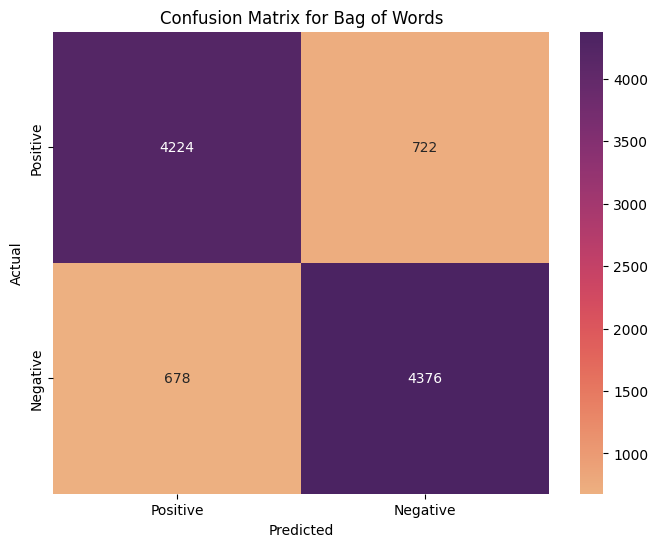

Accuracy score for LR with tfidf features:  0.871
Classification report for tfidf features
               precision    recall  f1-score   support

    Positive       0.88      0.86      0.87      5054
    Negative       0.86      0.89      0.87      4946

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



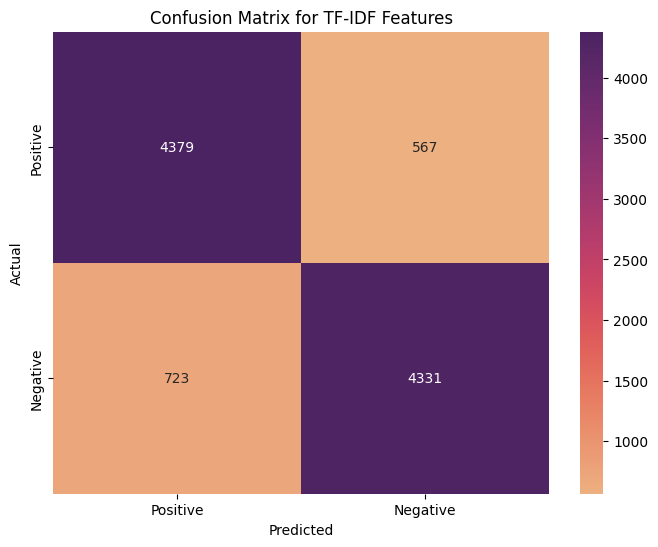

In [13]:
# Accuracy score for bag of words
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("Accuracy score for LR with bow: ", lr_bow_score)

# Classification report for bag of words
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names=['Positive', 'Negative'])
print('Classification report for bag of words\n', lr_bow_report)

# Confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
# print("Confusion matrix for bag of words\n", cm_bow)
plot_confusion_matrix(cm_bow, 'Confusion Matrix for Bag of Words', ['Positive', 'Negative'])

# Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("Accuracy score for LR with tfidf features: ", lr_tfidf_score)

# Classification report for tfidf features
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print('Classification report for tfidf features\n', lr_tfidf_report)

# Confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1 ,0])
# print("Confusion matrix for tfidf features\n", cm_tfidf)
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix for TF-IDF Features', ['Positive', 'Negative'])

#### Stochastic gradient descent

In [14]:
# Training the linear svm
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Fitting the svm for bag of words
svm_bow = svm.fit(cv_train_reviews, train_sentiments)

# Fitting the svm for tfidf features
svm_tfidf = svm.fit(tv_train_reviews, train_sentiments)

##### Model performance on test data

In [15]:
# Predicting the model for bag of words
svm_bow_predict = svm.predict(cv_test_reviews)
print(svm_bow_predict)

# Predicting the model for tfidf features
svm_tfidf_predict = svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 0 1 ... 0 0 1]
[1 0 1 ... 0 0 1]


##### Accuracy of the model

Accuracy score for SGD with bag of words:  0.8591
Classification report for bag of words
               precision    recall  f1-score   support

    Positive       0.85      0.88      0.86      5054
    Negative       0.87      0.84      0.85      4946

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



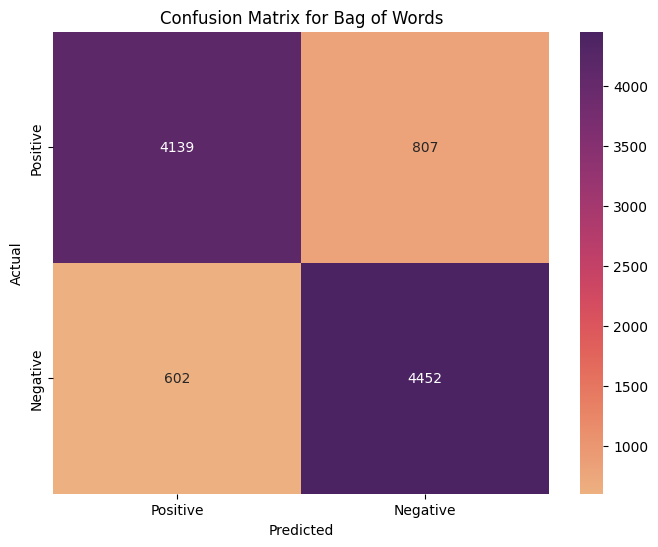

Accuracy score for SGD with tfidf features:  0.8699
Classification report for tfidf features
               precision    recall  f1-score   support

    Positive       0.88      0.86      0.87      5054
    Negative       0.86      0.88      0.87      4946

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



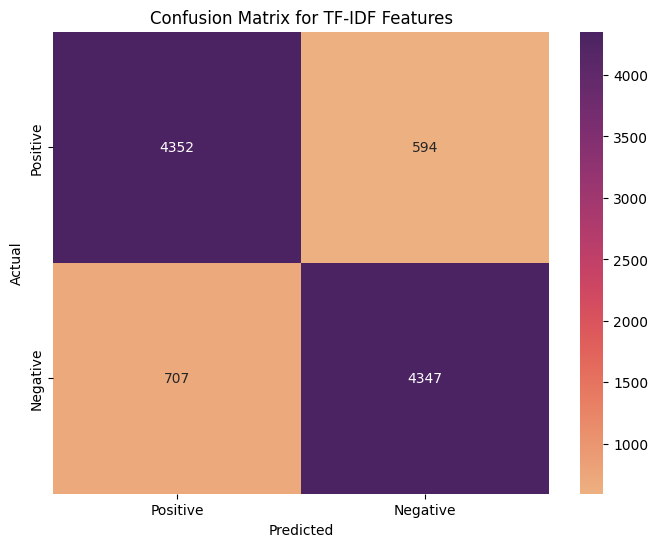

In [16]:
# Accuracy score for bag of words
svm_bow_score = accuracy_score(test_sentiments, svm_bow_predict)
print("Accuracy score for SGD with bag of words: ", svm_bow_score)

# Classification report for bag of words 
svm_bow_report = classification_report(test_sentiments, svm_bow_predict, target_names=['Positive', 'Negative'])
print("Classification report for bag of words\n", svm_bow_report)

# Confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, svm_bow_predict, labels=[1, 0])
# print("Confusion matrix for bag of words\n", cm_bow)
plot_confusion_matrix(cm_bow, 'Confusion Matrix for Bag of Words', ['Positive', 'Negative'])

# Accuracy score for tfidf features
svm_tfidf_score = accuracy_score(test_sentiments, svm_tfidf_predict)
print("Accuracy score for SGD with tfidf features: ", svm_tfidf_score)

# Classification report for tfidf features
svm_tfidf_report = classification_report(test_sentiments, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print("Classification report for tfidf features\n", svm_tfidf_report)

# Confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict, labels=[1, 0])
# print("Confusion matrix for tfidf features\n", cm_tfidf)
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix for TF-IDF Features', ['Positive', 'Negative'])

#### Multinomial Naive Bayes

In [17]:
# Training the model
mnb = MultinomialNB()

# Fitting the svm for bag of words
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)

# Fitting the svm for tfidf features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)

##### Model performance on test data

In [18]:
# Predicting the model for bag of words
mnb_bow_predict = mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

# Predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 1 ... 0 0 1]
[1 0 1 ... 0 0 1]


##### Accuracy of the model

Accuracy score for MNB with bag of words:  0.8347
Classification report for bag of words
               precision    recall  f1-score   support

    Positive       0.84      0.84      0.84      5054
    Negative       0.83      0.83      0.83      4946

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



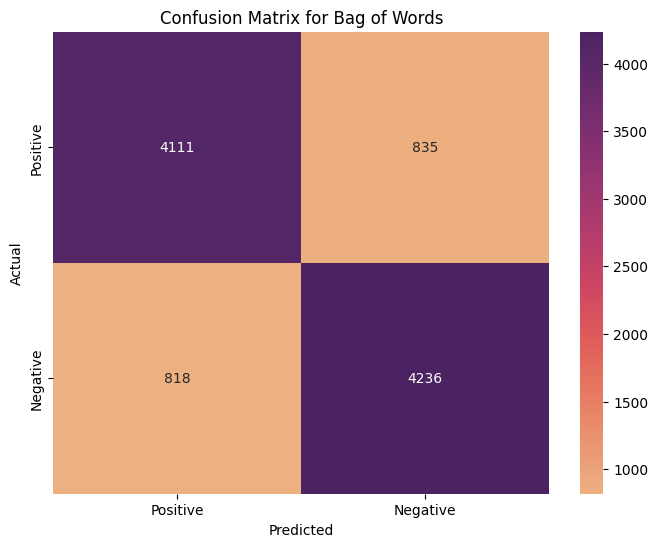

Accuracy score for MNB with tfidf features:  0.8364
Classification report for tfidf features
               precision    recall  f1-score   support

    Positive       0.86      0.81      0.83      5054
    Negative       0.82      0.86      0.84      4946

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



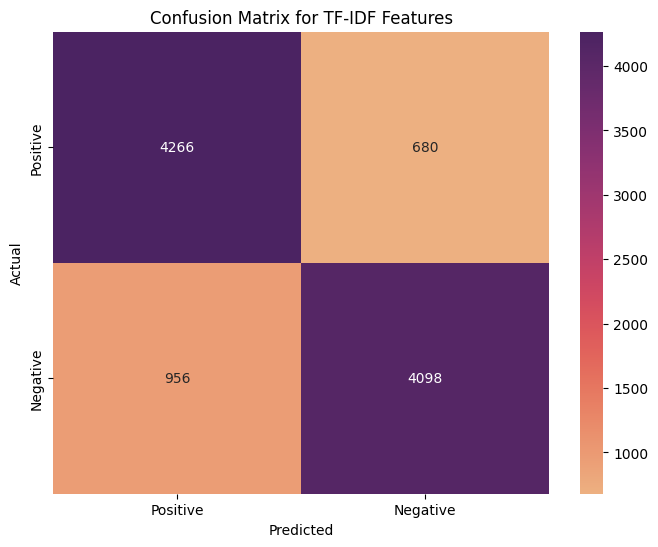

In [19]:
# Accuracy score for bag of words
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("Accuracy score for MNB with bag of words: ", mnb_bow_score)

# Classification report for bag of words 
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names=['Positive', 'Negative'])
print("Classification report for bag of words\n", mnb_bow_report)

# Confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
# print("Confusion matrix for bag of words\n", cm_bow)
plot_confusion_matrix(cm_bow, 'Confusion Matrix for Bag of Words', ['Positive', 'Negative'])

# Accuracy score for tfidf features
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("Accuracy score for MNB with tfidf features: ", mnb_tfidf_score)

# Classification report for tfidf features
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names=['Positive', 'Negative'])
print("Classification report for tfidf features\n", mnb_tfidf_report)

# Confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
# print("Confusion matrix for tfidf features\n", cm_tfidf)
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix for TF-IDF Features', ['Positive', 'Negative'])

## Improvements

### Developing our own ANN code

In [20]:
class MyANN:
    def __init__(self, hidden_layer_sizes=(5,), max_iter=100, learning_rate_init=0.1, random_state=None, verbose=False):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter
        self.learning_rate_init = learning_rate_init
        self.random_state = random_state
        self.verbose = verbose

        self.coefs_ = []
        self.intercepts_ = []
        self.activation_function = self.sigmoid
        self.activation_derivative = self.sigmoid_derivative

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def fit(self, X, y):
        # Convert sparse matrix to dense if needed
        if issparse(X):
            X = X.toarray()
        if issparse(y):
            y = y.toarray()

        # Initialize weights and biases
        np.random.seed(self.random_state)
        layer_sizes = [X.shape[1]] + list(self.hidden_layer_sizes) + [len(np.unique(y))]

        for i in range(len(layer_sizes) - 1):
            # Initialize weights and biases for each layer
            self.coefs_.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]))
            self.intercepts_.append(np.random.randn(layer_sizes[i + 1]))

        # Stochastic Gradient Descent
        for epoch in range(self.max_iter):
            loss = 0

            for i in range(X.shape[0]):
                # Forward pass
                activations = [X[i]]
                for j in range(len(self.coefs_)):
                    net_input = np.dot(activations[j], self.coefs_[j]) + self.intercepts_[j]
                    activation = self.activation_function(net_input)
                    activations.append(activation)

                # Calculate the loss
                loss += self.mean_squared_error(y[i], activations[-1])

                # Backward pass
                error = y[i] - activations[-1]
                deltas = [error * self.activation_derivative(activations[-1])]

                for j in range(len(activations) - 2, 0, -1):
                    delta = np.dot(deltas[-1], self.coefs_[j].T) * self.activation_derivative(activations[j])
                    deltas.append(delta)

                deltas.reverse()

                # Update weights and biases
                for j in range(len(self.coefs_)):
                    self.coefs_[j] += self.learning_rate_init * np.outer(activations[j], deltas[j])
                    self.intercepts_[j] += self.learning_rate_init * deltas[j]

            avg_loss = loss / X.shape[0]
            if self.verbose:
                print(f"Epoch {epoch + 1}/{self.max_iter} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        activations = [X]

        for j in range(len(self.coefs_)):
            net_input = np.dot(activations[j], self.coefs_[j]) + self.intercepts_[j]
            activation = self.activation_function(net_input)
            activations.append(activation)

        # Convert to class labels
        predictions = np.argmax(activations[-1], axis=1)
        return predictions

    def predict_proba(self, X):
        activations = [X]

        for j in range(len(self.coefs_)):
            net_input = np.dot(activations[j], self.coefs_[j]) + self.intercepts_[j]
            activation = self.activation_function(net_input)
            activations.append(activation)

        # Convert to class probabilities
        probabilities = activations[-1]
        return probabilities

In [21]:
ann_tool = neural_network.MLPClassifier(hidden_layer_sizes=(3,), max_iter=100, solver='sgd',
                                              verbose=10, random_state=1, learning_rate_init=0.001)

# Fitting the model for Bag of words
ann_tool_bow = ann_tool.fit(cv_train_reviews, train_sentiments)

# Fitting the model for tfidf features
ann_tool_tfidf = ann_tool.fit(tv_train_reviews, train_sentiments)

Iteration 1, loss = 0.68619723
Iteration 2, loss = 0.59266387
Iteration 3, loss = 0.51289536
Iteration 4, loss = 0.46166614
Iteration 5, loss = 0.42766088
Iteration 6, loss = 0.40351098
Iteration 7, loss = 0.38543606
Iteration 8, loss = 0.37124507
Iteration 9, loss = 0.35970976
Iteration 10, loss = 0.34998386
Iteration 11, loss = 0.34192716
Iteration 12, loss = 0.33480686
Iteration 13, loss = 0.32898418
Iteration 14, loss = 0.32353897
Iteration 15, loss = 0.31895512
Iteration 16, loss = 0.31488186
Iteration 17, loss = 0.31097051
Iteration 18, loss = 0.30793347
Iteration 19, loss = 0.30468878
Iteration 20, loss = 0.30194270
Iteration 21, loss = 0.29958114
Iteration 22, loss = 0.29735680
Iteration 23, loss = 0.29522138
Iteration 24, loss = 0.29334846
Iteration 25, loss = 0.29186506
Iteration 26, loss = 0.29009993
Iteration 27, loss = 0.28859493
Iteration 28, loss = 0.28719802
Iteration 29, loss = 0.28583510
Iteration 30, loss = 0.28476348
Iteration 31, loss = 0.28355584
Iteration 32, los

##### Model performance on test data

In [22]:
# Predicting the model for bag of words
ann_tool_bow_predict = ann_tool.predict(cv_test_reviews)
print(ann_tool_bow_predict)

# Predicting the model for tfidf features
ann_tool_tfidf_predict = ann_tool.predict(tv_test_reviews)
print(ann_tool_tfidf_predict)

[1 0 1 ... 0 0 1]
[1 0 1 ... 0 0 1]


##### Accuracy of the model

Accuracy score for ANN with bow:  0.8421
Classification report for bag of words
               precision    recall  f1-score   support

    Positive       0.82      0.87      0.85      5054
    Negative       0.86      0.81      0.84      4946

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



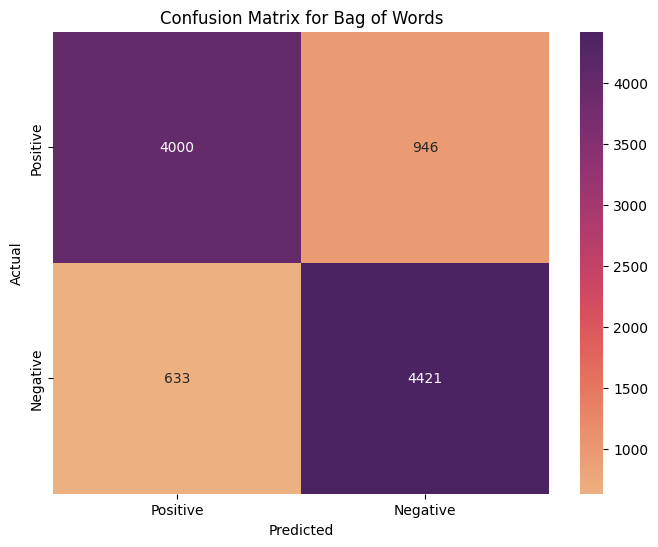

Accuracy score for ANN with tfidf features:  0.8593
Classification report for tfidf features
               precision    recall  f1-score   support

    Positive       0.87      0.85      0.86      5054
    Negative       0.85      0.87      0.86      4946

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



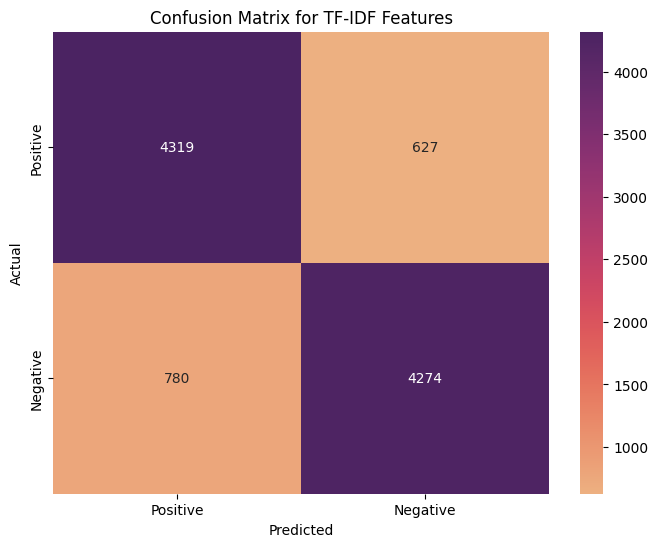

In [23]:
# Accuracy score for bag of words
ann_tool_bow_score = accuracy_score(test_sentiments, ann_tool_bow_predict)
print("Accuracy score for ANN with bow: ", ann_tool_bow_score)

# Classification report for bag of words
ann_tool_bow_report = classification_report(test_sentiments, ann_tool_bow_predict, target_names=['Positive', 'Negative'])
print('Classification report for bag of words\n', ann_tool_bow_report)

# Confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, ann_tool_bow_predict, labels=[1, 0])
# print("Confusion matrix for bag of words\n", cm_bow)
plot_confusion_matrix(cm_bow, 'Confusion Matrix for Bag of Words', ['Positive', 'Negative'])

# Accuracy score for tfidf features
ann_tool_tfidf_score = accuracy_score(test_sentiments, ann_tool_tfidf_predict)
print("Accuracy score for ANN with tfidf features: ", ann_tool_tfidf_score)

# Classification report for tfidf features
ann_tool_tfidf_report = classification_report(test_sentiments, ann_tool_tfidf_predict, target_names=['Positive', 'Negative'])
print('Classification report for tfidf features\n', ann_tool_tfidf_report)

# Confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, ann_tool_tfidf_predict, labels=[1 ,0])
# print("Confusion matrix for tfidf features\n", cm_tfidf)
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix for TF-IDF Features', ['Positive', 'Negative'])

In [ ]:
ann = MyANN(hidden_layer_sizes=(3, 3), max_iter=10, verbose=True, random_state=1, learning_rate_init=0.01)

cv_train_reviews = cv_train_reviews.toarray() if issparse(cv_train_reviews) else cv_train_reviews
tv_train_reviews = tv_train_reviews.toarray() if issparse(tv_train_reviews) else tv_train_reviews
train_sentiments = train_sentiments.toarray() if issparse(train_sentiments) else train_sentiments

# Fitting the model for Bag of words
ann_bow = ann.fit(cv_train_reviews, train_sentiments)

# Fitting the model for tfidf features
ann_tfidf = ann.fit(tv_train_reviews, train_sentiments)

In [ ]:
# Predicting the model for bag of words
ann_bow_predict = ann_tool.predict(cv_test_reviews)
print(ann_bow_predict)

# Predicting the model for tfidf features
ann_tfidf_predict = ann_tool.predict(tv_test_reviews)
print(ann_tfidf_predict)

In [ ]:
# Accuracy score for bag of words
ann_bow_score = accuracy_score(test_sentiments, ann_bow_predict)
print("Accuracy score for ANN with bow: ", ann_bow_score)

# Classification report for bag of words
ann_bow_report = classification_report(test_sentiments, ann_bow_predict, target_names=['Positive', 'Negative'])
print('Classification report for bag of words\n', ann_bow_report)

# Confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, ann_bow_predict, labels=[1, 0])
# print("Confusion matrix for bag of words\n", cm_bow)
plot_confusion_matrix(cm_bow, 'Confusion Matrix for Bag of Words', ['Positive', 'Negative'])

# Accuracy score for tfidf features
ann_tfidf_score = accuracy_score(test_sentiments, ann_tfidf_predict)
print("Accuracy score for ANN with tfidf features: ", ann_tool_tfidf_score)

# Classification report for tfidf features
ann_tfidf_report = classification_report(test_sentiments, ann_tfidf_predict, target_names=['Positive', 'Negative'])
print('Classification report for tfidf features\n', ann_tfidf_report)

# Confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, ann_tfidf_predict, labels=[1 ,0])
# print("Confusion matrix for tfidf features\n", cm_tfidf)
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix for TF-IDF Features', ['Positive', 'Negative'])

## Example of usage for the model

In [24]:
# Define a function to preprocess a single review
def preprocess_review(review):
    review = denoise_text(review)
    review = remove_special_characters(review)
    review = simple_stemmer(review)
    review = remove_stopwords(review)
    return review

# Function to predict the sentiment of a new review
def predict_sentiment(review, model, vectorizer):
    # Preprocess the review
    review = preprocess_review(review)
    
    # Transform the review using the TF-IDF vectorizer
    review_tfidf = vectorizer.transform([review])
    
    # Predict the sentiment
    sentiment = model.predict(review_tfidf)
    
    # Map the prediction to a human-readable label
    sentiment_label = 'Positive' if sentiment[0] == 1 else 'Negative'
    
    return sentiment_label

# Select a review from the dataset
imdb_data = pd.read_csv('dataset/IMDB Dataset.csv')
review = imdb_data['review'].iloc[5]
sample_review = imdb_data['review'].iloc[5]
actual_sentiment = imdb_data['sentiment'].iloc[5]

# Predict the sentiment of the selected review
predicted_sentiment = predict_sentiment(sample_review, ann_tool, tv)

print("Sample Review:\n", review)
print("\nActual Sentiment:", actual_sentiment)
print("\nPredicted Sentiment:", predicted_sentiment)

Sample Review:
 Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they'd all be "up" for this movie.

Actual Sentiment: positive

Predicted Sentiment: Positive
